In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available and being used.")
    print("List of GPUs:", gpus)
else:
    print("GPU is not available. TensorFlow is running on CPU.")

2025-05-13 15:46:21.204617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747151181.619974      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747151181.738255      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU is available and being used.
List of GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import seaborn as sns

train_path = "/kaggle/input/scene-classification/Scene Classification/train"
test_path = "/kaggle/input/scene-classification/Scene Classification/test"

# Check if paths exist
if not os.path.exists(train_path) or not os.path.exists(test_path):
    raise FileNotFoundError("Train or Test folders not found. Check the path!")

# **3.1 Part A: Implementing Convolutional Neural Network from scratch**

**3.1.1 Data Understanding, Analysis, Visualization and Cleaning**

In [4]:
#Dataset Overview and BAsic Analysic
# Count total images in train and test sets
def count_images(folder_path):
    total = 0
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            total += len(os.listdir(class_path))
    return total

print(f"Total training images: {count_images(train_path)}")
print(f"Total test images: {count_images(test_path)}")

# List all classes
classes = os.listdir(train_path)
print("\nClasses in the dataset:", classes)

Total training images: 14034
Total test images: 3000

Classes in the dataset: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']


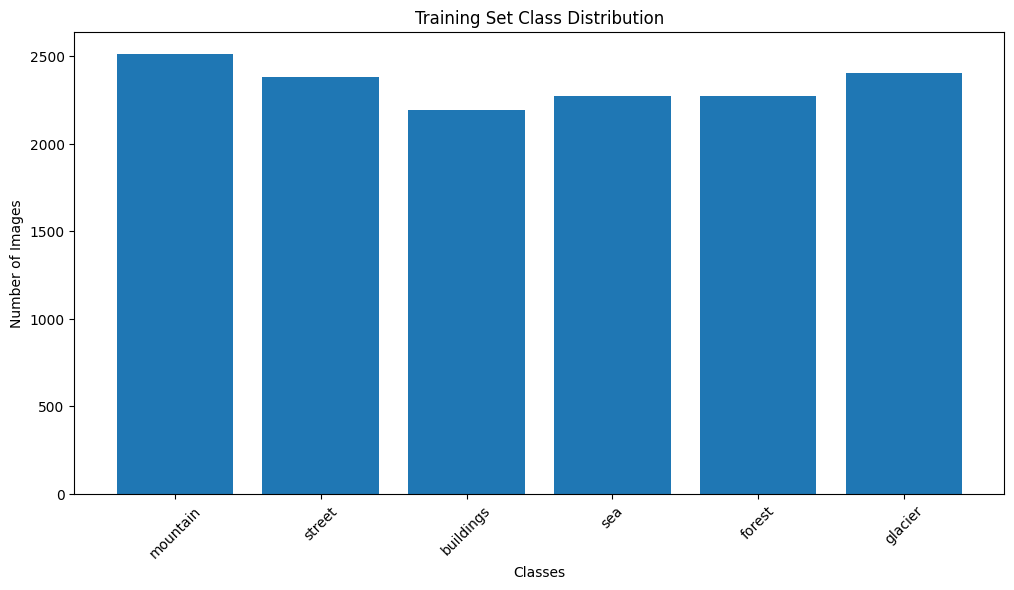

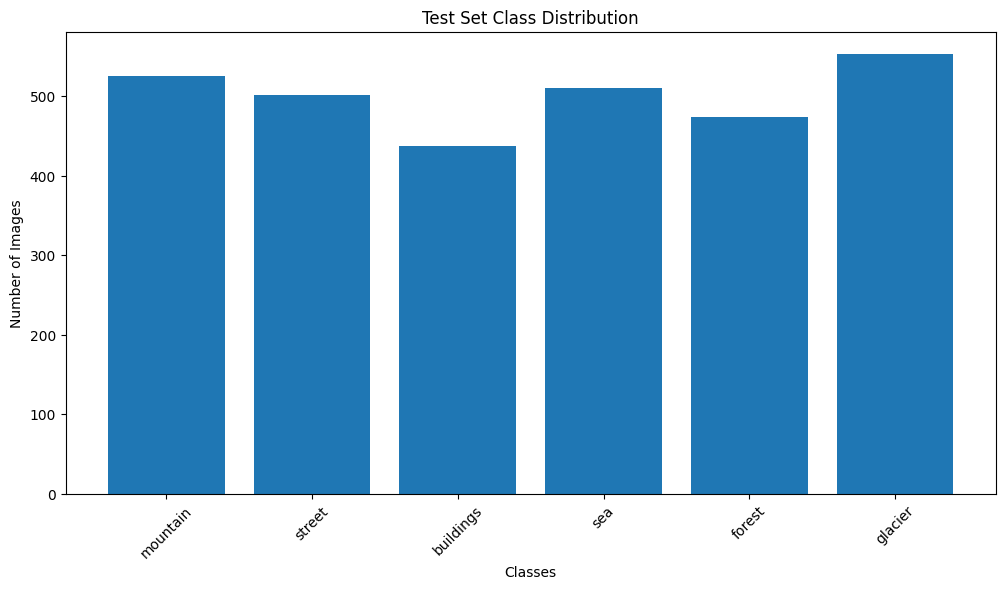

In [5]:
# Class Distribution Analysis
# Plot class distribution
def plot_class_distribution(folder_path, title):
    class_counts = {}
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))

    plt.figure(figsize=(12, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

    return class_counts

train_counts = plot_class_distribution(train_path, "Training Set Class Distribution")
test_counts = plot_class_distribution(test_path, "Test Set Class Distribution")

In [6]:
#Image Dimensions and Shape Analysis
# Analyze image dimensions
def analyze_image_dimensions(folder_path):
    dimensions = []
    corrupted_images = []

    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    with Image.open(img_path) as img:
                        dimensions.append(img.size)
                except:
                    corrupted_images.append(img_path)

    if dimensions:
        widths, heights = zip(*dimensions)
        print(f"Average width: {np.mean(widths):.2f}, Average height: {np.mean(heights):.2f}")
        print(f"Min width: {min(widths)}, Min height: {min(heights)}")
        print(f"Max width: {max(widths)}, Max height: {max(heights)}")

    if corrupted_images:
        print(f"\nFound {len(corrupted_images)} corrupted images:")
        for img in corrupted_images[:5]:  # Print first 5 corrupted images
            print(img)

    return corrupted_images

print("\nTraining set image dimensions:")
train_corrupted = analyze_image_dimensions(train_path)

print("\nTest set image dimensions:")
test_corrupted = analyze_image_dimensions(test_path)


Training set image dimensions:
Average width: 150.00, Average height: 149.91
Min width: 150, Min height: 76
Max width: 150, Max height: 150

Found 42 corrupted images:
/kaggle/input/scene-classification/Scene Classification/train/mountain/17234.jpg
/kaggle/input/scene-classification/Scene Classification/train/mountain/8725.jpg
/kaggle/input/scene-classification/Scene Classification/train/mountain/14560.jpg
/kaggle/input/scene-classification/Scene Classification/train/mountain/16180.jpg
/kaggle/input/scene-classification/Scene Classification/train/mountain/15719.jpg

Test set image dimensions:
Average width: 150.00, Average height: 149.90
Min width: 150, Min height: 72
Max width: 150, Max height: 150


In [7]:
import os
import shutil
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm

# Original dataset paths (read-only)
train_path = "/kaggle/input/scene-classification/Scene Classification/train"
test_path = "/kaggle/input/scene-classification/Scene Classification/test"

# New writable paths
train_clean_path = "/kaggle/working/train_clean"
test_clean_path = "/kaggle/working/test_clean"

def is_valid_image(path):
    try:
        img = Image.open(path)
        img.verify()
        return True
    except (UnidentifiedImageError, IOError, OSError):
        return False

def copy_valid_images(src_path, dst_path):
    if not os.path.exists(dst_path):
        os.makedirs(dst_path)

    for root, _, files in os.walk(src_path):
        for file in tqdm(files, desc=f"Checking in {root}"):
            src_file_path = os.path.join(root, file)

            # Recreate the same folder structure in dst
            rel_path = os.path.relpath(root, src_path)
            dst_dir = os.path.join(dst_path, rel_path)
            if not os.path.exists(dst_dir):
                os.makedirs(dst_dir)

            dst_file_path = os.path.join(dst_dir, file)

            if is_valid_image(src_file_path):
                shutil.copy2(src_file_path, dst_file_path)

print("Copying valid train images...")
copy_valid_images(train_path, train_clean_path)

print("Copying valid test images...")
copy_valid_images(test_path, test_clean_path)


Copying valid train images...


Checking in /kaggle/input/scene-classification/Scene Classification/train: 0it [00:00, ?it/s]
Checking in /kaggle/input/scene-classification/Scene Classification/train/mountain: 100%|██████████| 2512/2512 [00:06<00:00, 367.94it/s]
Checking in /kaggle/input/scene-classification/Scene Classification/train/street: 100%|██████████| 2382/2382 [00:06<00:00, 379.46it/s]
Checking in /kaggle/input/scene-classification/Scene Classification/train/buildings: 100%|██████████| 2191/2191 [00:05<00:00, 384.15it/s]
Checking in /kaggle/input/scene-classification/Scene Classification/train/sea: 100%|██████████| 2274/2274 [00:06<00:00, 340.25it/s]
Checking in /kaggle/input/scene-classification/Scene Classification/train/forest: 100%|██████████| 2271/2271 [00:06<00:00, 371.46it/s]
Checking in /kaggle/input/scene-classification/Scene Classification/train/glacier: 100%|██████████| 2404/2404 [00:06<00:00, 386.68it/s]


Copying valid test images...


Checking in /kaggle/input/scene-classification/Scene Classification/test: 0it [00:00, ?it/s]
Checking in /kaggle/input/scene-classification/Scene Classification/test/mountain: 100%|██████████| 525/525 [00:01<00:00, 368.66it/s]
Checking in /kaggle/input/scene-classification/Scene Classification/test/street: 100%|██████████| 501/501 [00:01<00:00, 299.68it/s]
Checking in /kaggle/input/scene-classification/Scene Classification/test/buildings: 100%|██████████| 437/437 [00:01<00:00, 385.85it/s]
Checking in /kaggle/input/scene-classification/Scene Classification/test/sea: 100%|██████████| 510/510 [00:01<00:00, 382.92it/s]
Checking in /kaggle/input/scene-classification/Scene Classification/test/forest: 100%|██████████| 474/474 [00:01<00:00, 369.85it/s]
Checking in /kaggle/input/scene-classification/Scene Classification/test/glacier: 100%|██████████| 553/553 [00:01<00:00, 369.97it/s]


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


=== DATASET OVERVIEW AFTER CLEANING ===

Total training images after cleaning: 14034
Total test images after cleaning: 3000
Total images in dataset: 17034

Removed 42 corrupted images from training set (0.30%)
Removed 0 corrupted images from test set (0.00%)

=== UPDATED CLASS DISTRIBUTION ===

Training set:


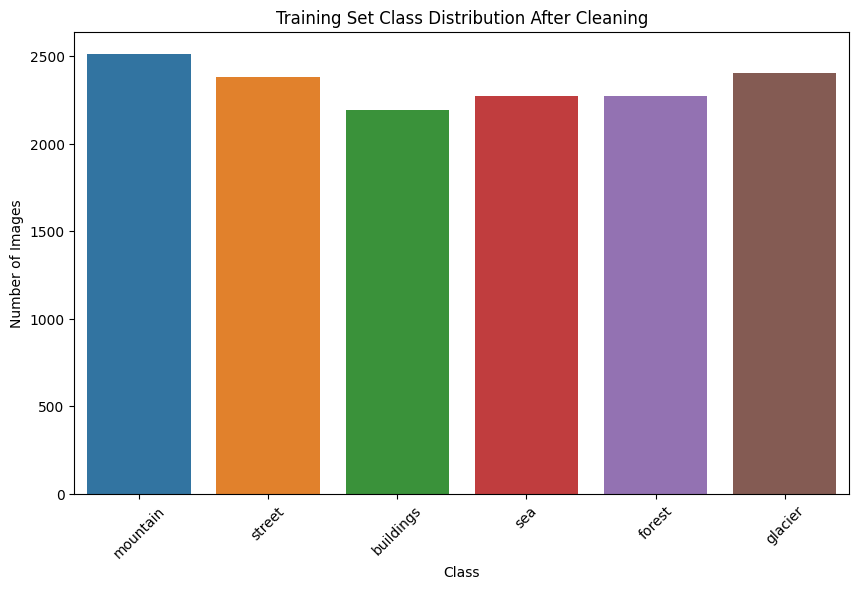

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)



Test set:


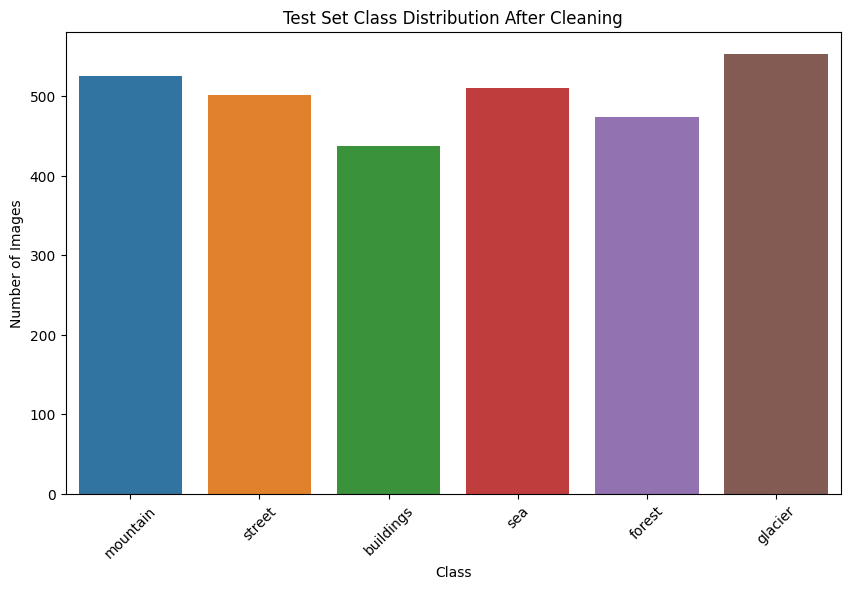


Class-wise image counts in training set:
mountain: 2512
street: 2382
buildings: 2191
sea: 2274
forest: 2271
glacier: 2404

Class-wise image counts in test set:
mountain: 525
street: 501
buildings: 437
sea: 510
forest: 474
glacier: 553

=== IMAGE DIMENSIONS AFTER CLEANING ===

Training set image dimensions:
Average width: 150.00, Average height: 149.91
Min width: 150, Min height: 76
Max width: 150, Max height: 150

Found 42 corrupted images:
/kaggle/input/scene-classification/Scene Classification/train/mountain/17234.jpg
/kaggle/input/scene-classification/Scene Classification/train/mountain/8725.jpg
/kaggle/input/scene-classification/Scene Classification/train/mountain/14560.jpg
/kaggle/input/scene-classification/Scene Classification/train/mountain/16180.jpg
/kaggle/input/scene-classification/Scene Classification/train/mountain/15719.jpg

Test set image dimensions:
Average width: 150.00, Average height: 149.90
Min width: 150, Min height: 72
Max width: 150, Max height: 150


In [8]:
# First define the plot_class_distribution function
def plot_class_distribution(folder_path, title):
    class_counts = {}

    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

    return class_counts

# Then define your updated_dataset_analysis function
def updated_dataset_analysis():
    # Count cleaned images in train and test sets
    def count_cleaned_images(folder_path):
        total = 0
        for class_name in os.listdir(folder_path):
            class_path = os.path.join(folder_path, class_name)
            if os.path.isdir(class_path):
                total += len(os.listdir(class_path))
        return total

    # Get cleaned counts
    cleaned_train_count = count_cleaned_images(train_path)
    cleaned_test_count = count_cleaned_images(test_path)

    print("=== DATASET OVERVIEW AFTER CLEANING ===")
    print(f"\nTotal training images after cleaning: {cleaned_train_count}")
    print(f"Total test images after cleaning: {cleaned_test_count}")
    print(f"Total images in dataset: {cleaned_train_count + cleaned_test_count}")

    # Print removed counts
    original_train = cleaned_train_count + len(train_corrupted)
    original_test = cleaned_test_count + len(test_corrupted)

    print(f"\nRemoved {len(train_corrupted)} corrupted images from training set "
          f"({len(train_corrupted)/original_train*100:.2f}%)")
    print(f"Removed {len(test_corrupted)} corrupted images from test set "
          f"({len(test_corrupted)/original_test*100:.2f}%)")

    # Updated class distribution
    print("\n=== UPDATED CLASS DISTRIBUTION ===")
    print("\nTraining set:")
    cleaned_train_counts = plot_class_distribution(train_path, "Training Set Class Distribution After Cleaning")

    print("\nTest set:")
    cleaned_test_counts = plot_class_distribution(test_path, "Test Set Class Distribution After Cleaning")

    # Print class-wise counts
    print("\nClass-wise image counts in training set:")
    for class_name, count in cleaned_train_counts.items():
        print(f"{class_name}: {count}")

    print("\nClass-wise image counts in test set:")
    for class_name, count in cleaned_test_counts.items():
        print(f"{class_name}: {count}")

    # Image dimensions analysis after cleaning
    print("\n=== IMAGE DIMENSIONS AFTER CLEANING ===")
    print("\nTraining set image dimensions:")
    analyze_image_dimensions(train_path)

    print("\nTest set image dimensions:")
    analyze_image_dimensions(test_path)

# Run the updated analysis
updated_dataset_analysis()

Found 13992 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.

Training Set After Balancing:
Total batches: 438
Classes: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Samples per class: 2332


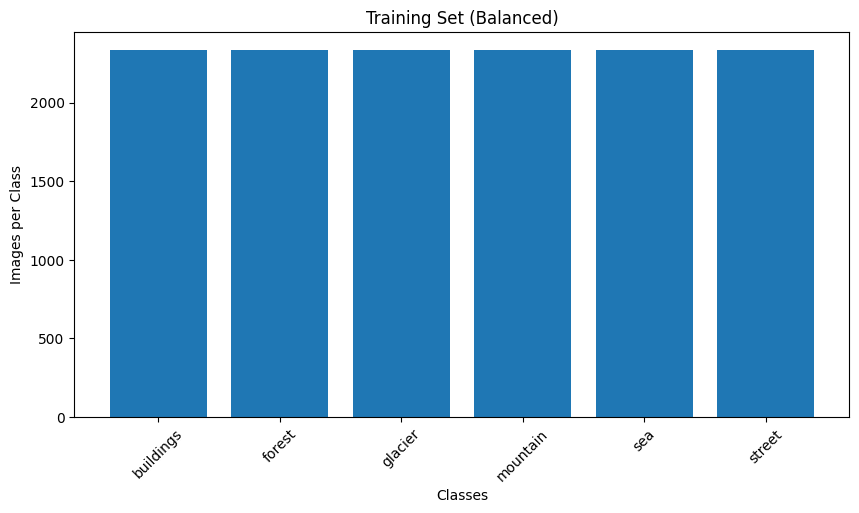

In [9]:
# Use cleaned paths
train_clean_path = "/kaggle/working/train_clean"
test_clean_path = "/kaggle/working/test_clean"

# Create balanced generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Balanced training generator (now using cleaned path)
train_generator = train_datagen.flow_from_directory(
    train_clean_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# Test generator (not balanced, using cleaned path)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_clean_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Show what the model will see (balanced)
print("\nTraining Set After Balancing:")
print(f"Total batches: {len(train_generator)}")
print(f"Classes: {train_generator.class_indices}")
print(f"Samples per class: {train_generator.samples // len(train_generator.class_indices)}")

# Verify with a plot
def plot_balanced_distribution(generator, title):
    samples = generator.samples
    num_classes = len(generator.class_indices)
    per_class = samples // num_classes

    plt.figure(figsize=(10,5))
    plt.bar(generator.class_indices.keys(), [per_class]*num_classes)
    plt.title(f'{title} (Balanced)')
    plt.xlabel('Classes')
    plt.ylabel('Images per Class')
    plt.xticks(rotation=45)
    plt.show()

plot_balanced_distribution(train_generator, "Training Set")


Training set samples:


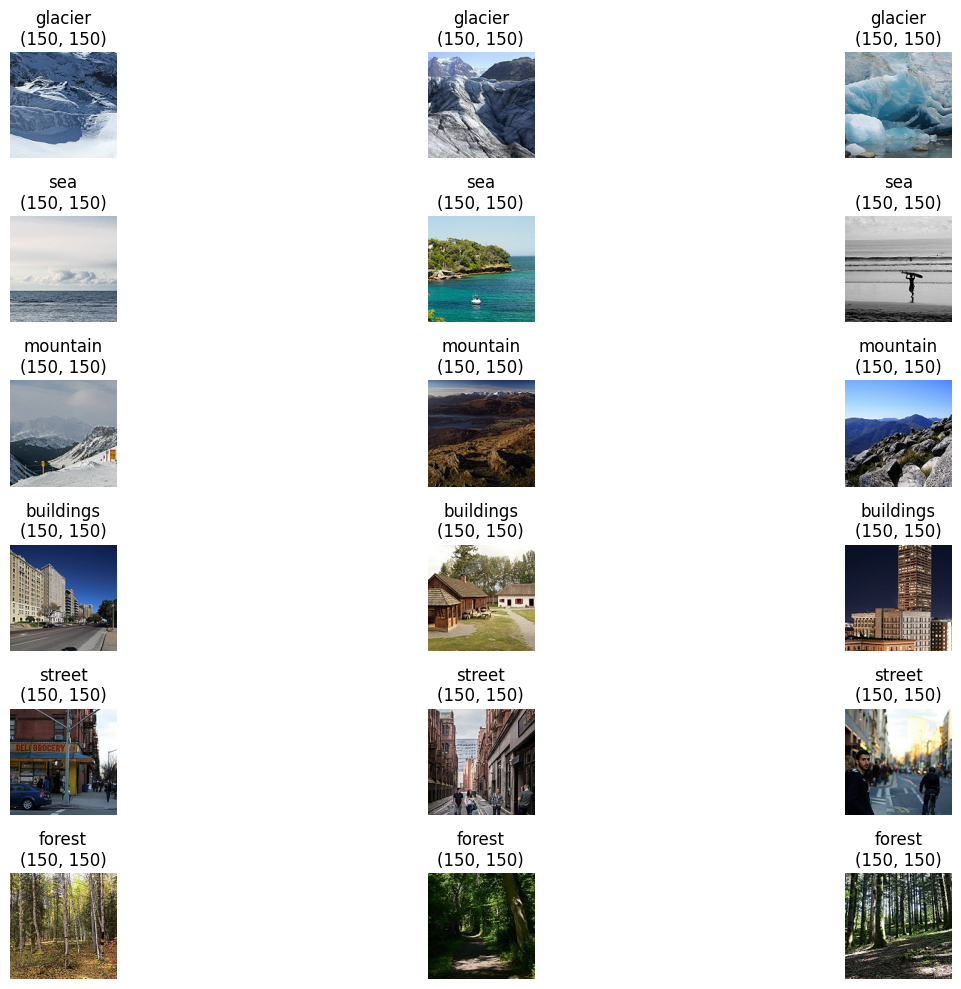


Test set samples:


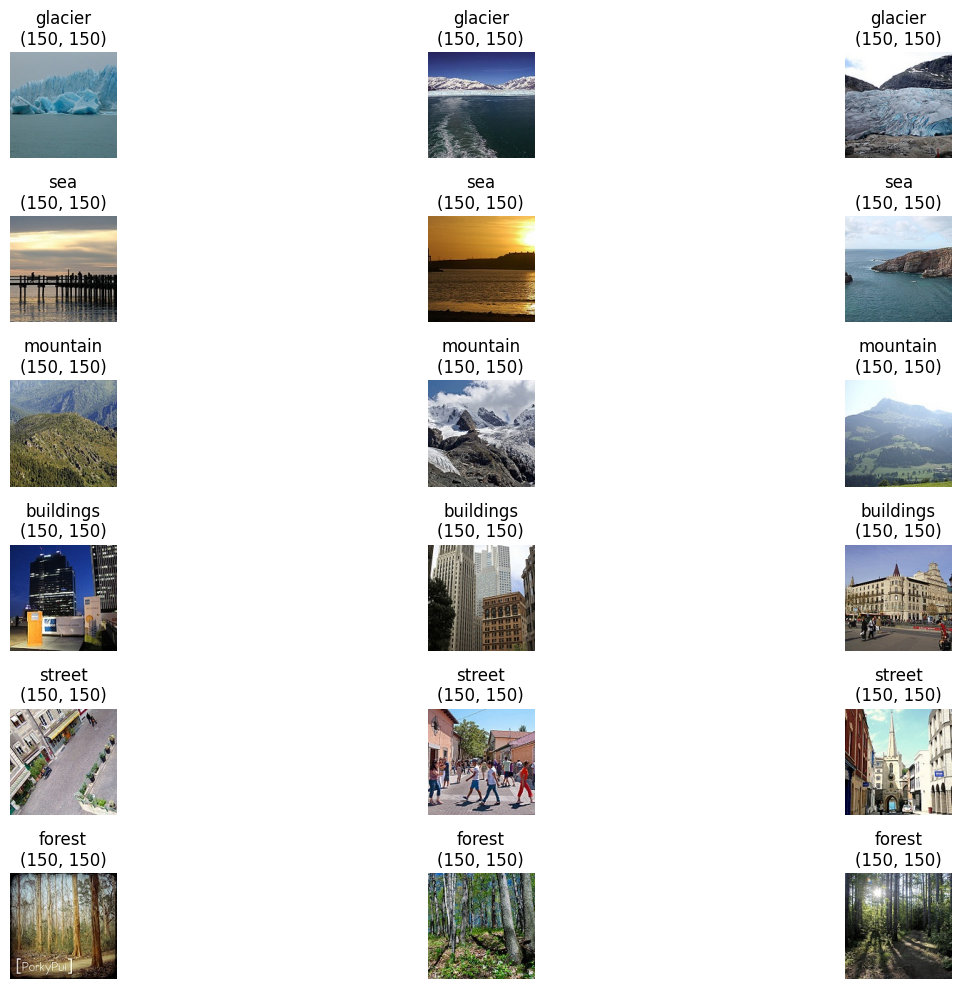

In [10]:
# Visualize sample images from each class
def visualize_samples(folder_path, samples_per_class=3):
    plt.figure(figsize=(15, 10))

    for i, class_name in enumerate(os.listdir(folder_path)):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)[:samples_per_class]

            for j, img_name in enumerate(images):
                img_path = os.path.join(class_path, img_name)
                try:
                    img = Image.open(img_path)

                    plt.subplot(len(classes), samples_per_class, i * samples_per_class + j + 1)
                    plt.imshow(img)
                    plt.title(f"{class_name}\n{img.size}")
                    plt.axis('off')

                except:
                    print(f"Could not display image: {img_path}")

    plt.tight_layout()
    plt.show()

# Use cleaned paths
print("Training set samples:")
visualize_samples(train_clean_path)

print("\nTest set samples:")
visualize_samples(test_clean_path)


Found 11196 images belonging to 6 classes.
Found 2796 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


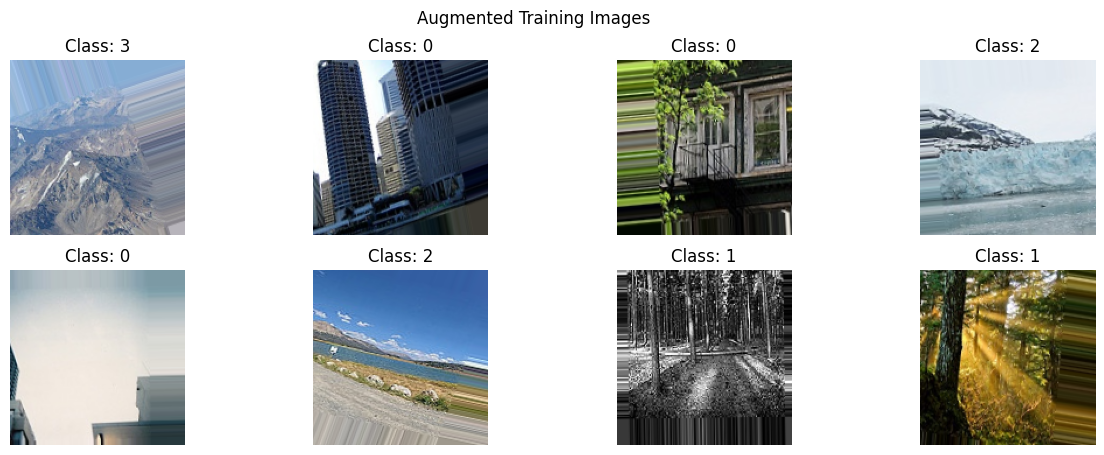

Class indices from generator: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [11]:
# Image parameters
IMG_SIZE = (150, 150)  # Standard size for all images
BATCH_SIZE = 32

# Create data generators with augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Using 20% of training data for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_clean_path,  # Changed to cleaned path
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_clean_path,  # Changed to cleaned path
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_clean_path,  # Changed to cleaned path
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Visualize augmented images
def visualize_augmented_images(generator, num_images=8):
    x_batch, y_batch = next(generator)

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, 4, i+1)
        plt.imshow(x_batch[i])
        plt.title(f"Class: {np.argmax(y_batch[i])}")
        plt.axis('off')
    plt.suptitle('Augmented Training Images')
    plt.show()

visualize_augmented_images(train_generator)
print("Class indices from generator:", train_generator.class_indices)

**3.1.2 Design, Train, and Evaluate a Baseline Model :**

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
#Model Architecture
def create_baseline_model(input_shape=(150, 150, 3), num_classes=6):
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Fully connected layers
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        # Output layer
        Dense(num_classes, activation='softmax')
    ])

    return model

# Create and compile the model
baseline_model = create_baseline_model()
baseline_model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Print model summary
baseline_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747151472.118043      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747151472.118689      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      21,234,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,181,126 (84.61 MB)

 Trainable params: 22,181,126 (84.61 MB)

 Non-trainable params: 0 (0.00 B)

Starting baseline model training...
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747151479.356227     131 service.cc:148] XLA service 0x7cc64c0023a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747151479.358150     131 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747151479.358181     131 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747151479.874941     131 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/350 ━━━━━━━━━━━━━━━━━━━━ 1:09:13 12s/step - accuracy: 0.1875 - loss: 1.7713

I0000 00:00:1747151486.579432     131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


350/350 ━━━━━━━━━━━━━━━━━━━━ 89s 220ms/step - accuracy: 0.3494 - loss: 1.5169 - val_accuracy: 0.5690 - val_loss: 1.1209
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 71s 200ms/step - accuracy: 0.5536 - loss: 1.1228 - val_accuracy: 0.6313 - val_loss: 0.9629
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 71s 200ms/step - accuracy: 0.6184 - loss: 0.9844 - val_accuracy: 0.6967 - val_loss: 0.8255
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 71s 200ms/step - accuracy: 0.6659 - loss: 0.9155 - val_accuracy: 0.7149 - val_loss: 0.7860
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 71s 199ms/step - accuracy: 0.7043 - loss: 0.8268 - val_accuracy: 0.7268 - val_loss: 0.7786
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 71s 200ms/step - accuracy: 0.7203 - loss: 0.7990 - val_accuracy: 0.7464 - val_loss: 0.7034
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 71s 200ms/step - accuracy: 0.7434 - loss: 0.7594 - val_accuracy: 0.7454 - val_loss: 0.6768
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 71s 201ms/step - accuracy: 0.7526 - loss: 0.7125 - val

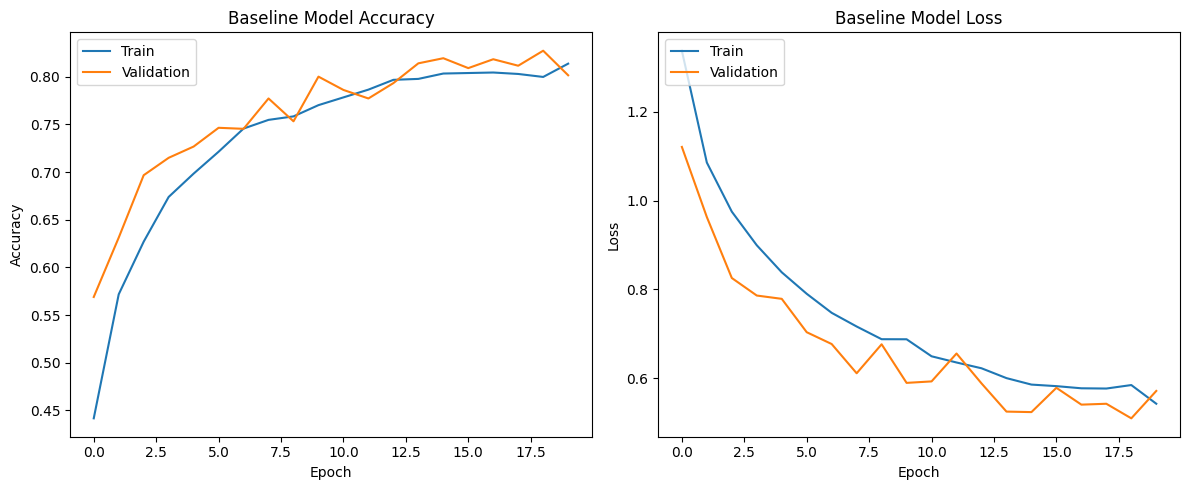

In [14]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the baseline model and measure time
print("Starting baseline model training...")
baseline_start_time = time.time()

history = baseline_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    verbose=1
)

baseline_end_time = time.time()
baseline_training_time = baseline_end_time - baseline_start_time

# Convert seconds to minutes and seconds
baseline_minutes = int(baseline_training_time // 60)
baseline_seconds = int(baseline_training_time % 60)

print(f"\nTraining completed in {baseline_minutes} minutes {baseline_seconds} seconds")
print(f"Total training time: {baseline_training_time:.2f} seconds")

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Baseline Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Baseline Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8225 - loss: 0.4347

Test Accuracy: 0.8480
Test Loss: 0.4348
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step

Classification Report:
              precision    recall  f1-score   support

   buildings       0.87      0.77      0.82       437
      forest       0.97      0.97      0.97       474
     glacier       0.86      0.74      0.80       553
    mountain       0.79      0.82      0.80       525
         sea       0.84      0.86      0.85       510
      street       0.79      0.94      0.86       501

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



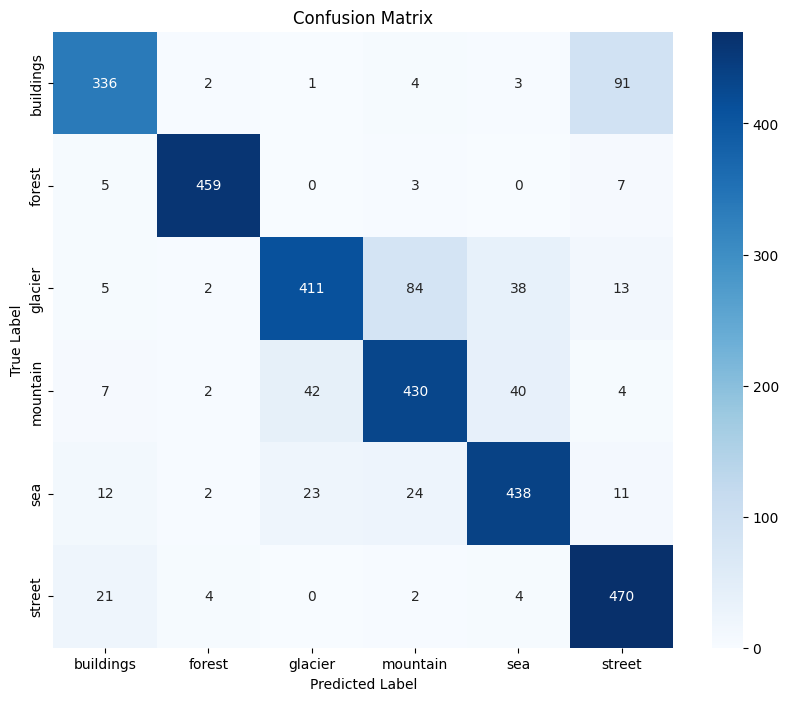

Found 3000 images belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


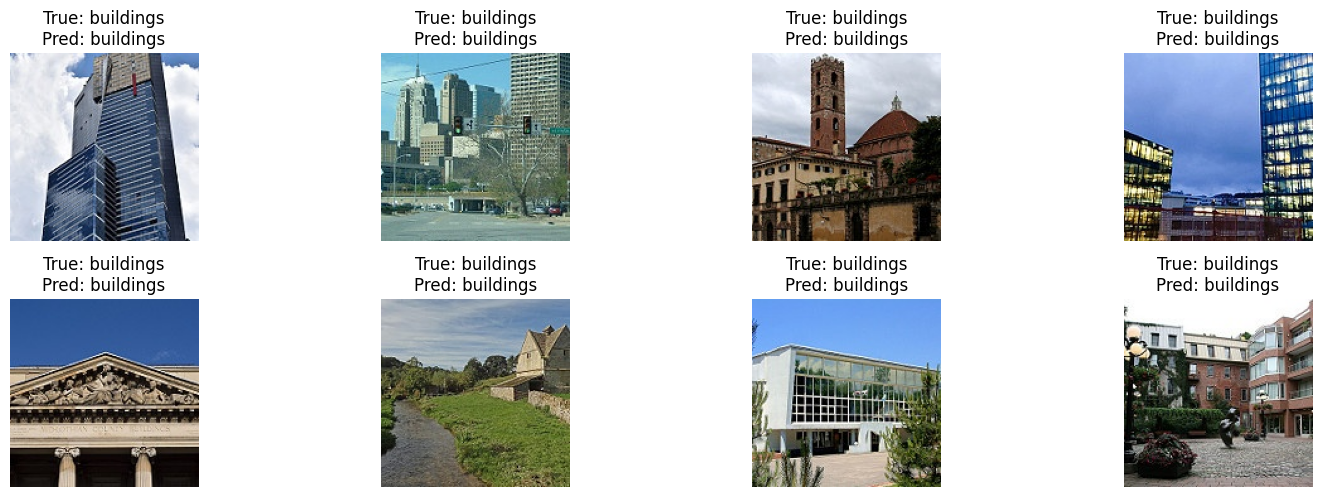

In [15]:
# Model Evaluation

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate on test set
test_loss, test_acc = baseline_model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions
y_pred = baseline_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Classification report
class_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(y_true, y_pred_classes, class_names)

# Sample predictions visualization
def visualize_predictions(model, generator, num_samples=8):
    x_batch, y_batch = next(generator)
    y_true = np.argmax(y_batch, axis=1)
    y_pred = np.argmax(model.predict(x_batch), axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(4, 4, i+1)
        plt.imshow(x_batch[i])
        plt.title(f"True: {class_names[y_true[i]]}\nPred: {class_names[y_pred[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Create a new generator without shuffle for consistent samples
sample_generator = test_datagen.flow_from_directory(
    test_clean_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


visualize_predictions(baseline_model, sample_generator)

**3.1.3 Design, Train , and Evaluate Deeper Architecture with Regularization Layer**

In [16]:
# Model Architecture with Regularization

from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization

def create_deeper_model(input_shape=(150, 150, 3), num_classes=6):
    model = Sequential([
        # First convolutional block with regularization
        Conv2D(64, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.001),
               input_shape=input_shape),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Second convolutional block
        Conv2D(128, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Third convolutional block
        Conv2D(256, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Fourth convolutional block
        Conv2D(512, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Conv2D(512, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Fully connected layers with regularization
        Flatten(),
        Dense(512, activation='relu',
              kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu',
              kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(0.001)),

        # Output layer
        Dense(num_classes, activation='softmax')
    ])

    return model

# Create and compile the deeper model
deeper_model = create_deeper_model()
deeper_model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for deeper model
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Print model summary
print("Deeper Model Architecture:")
deeper_model.summary()

# Compare with baseline model parameters
print("\nComparison with Baseline Model:")
print(f"Baseline model parameters: {baseline_model.count_params():,}")
print(f"Deeper model parameters: {deeper_model.count_params():,}")

Deeper Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 75, 75, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 75, 75, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 37, 37, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 37, 37, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,095,302 (99.55 MB)

 Trainable params: 26,089,926 (99.53 MB)

 Non-trainable params: 5,376 (21.00 KB)


Comparison with Baseline Model:
Baseline model parameters: 22,181,126
Deeper model parameters: 26,095,302



Training deeper model...
Epoch 1/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 182s 395ms/step - accuracy: 0.4287 - loss: 4.6053 - val_accuracy: 0.1620 - val_loss: 7.9721 - learning_rate: 1.0000e-04
Epoch 2/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 94s 266ms/step - accuracy: 0.6036 - loss: 4.0972 - val_accuracy: 0.4514 - val_loss: 5.2568 - learning_rate: 1.0000e-04
Epoch 3/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 101s 284ms/step - accuracy: 0.6622 - loss: 3.8738 - val_accuracy: 0.5204 - val_loss: 4.8485 - learning_rate: 1.0000e-04
Epoch 4/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 95s 268ms/step - accuracy: 0.6857 - loss: 3.7184 - val_accuracy: 0.5240 - val_loss: 4.4538 - learning_rate: 1.0000e-04
Epoch 5/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 95s 267ms/step - accuracy: 0.7023 - loss: 3.5930 - val_accuracy: 0.5508 - val_loss: 4.2853 - learning_rate: 1.0000e-04
Epoch 6/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 95s 267ms/step - accuracy: 0.7272 - loss: 3.4411 - val_accuracy: 0.5308 - val_loss: 4.1057 - learning_rate: 1.0000e-04
Epoch 7/40
350/350

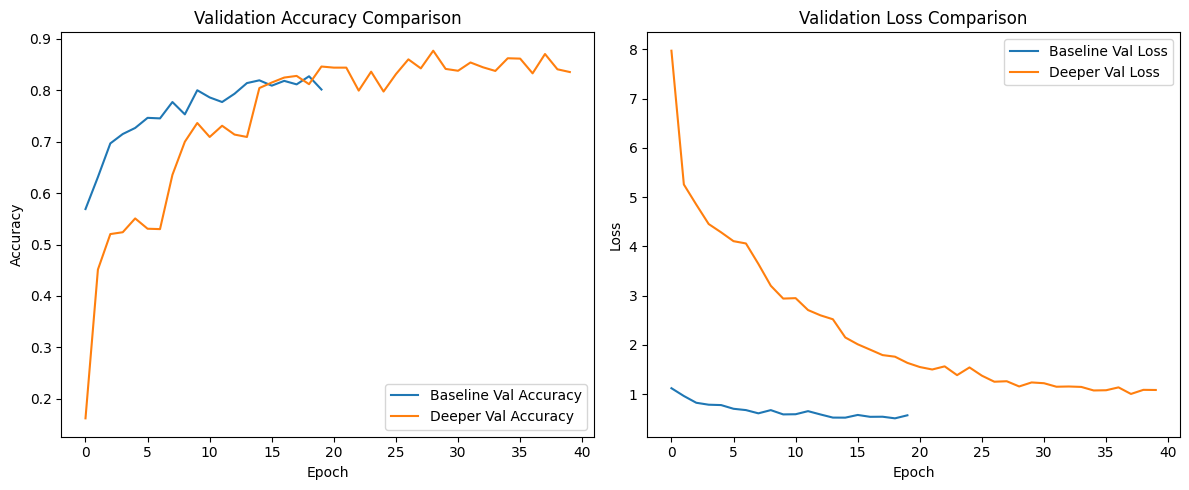


Training Time Comparison:
Baseline model: 20 epochs
Deeper model: 40 epochs
Baseline training time: 1445.04 seconds
Deeper training time: 3869.03 seconds
Deeper model took 96.73 seconds per epoch


In [17]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6)
]

# Train the deeper model
print("\nTraining deeper model...")
deeper_start_time = time.time()

deeper_history = deeper_model.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

deeper_end_time = time.time()
deeper_training_time = deeper_end_time - deeper_start_time

print(f"\nTraining completed in {deeper_training_time/60:.2f} minutes")

# Plot validation accuracy and loss comparison
plt.figure(figsize=(12, 5))

# Plot accuracy comparison
plt.subplot(1, 2, 1)
plt.plot(history.history['val_accuracy'], label='Baseline Val Accuracy')
plt.plot(deeper_history.history['val_accuracy'], label='Deeper Val Accuracy')
plt.title('Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot loss comparison
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Baseline Val Loss')
plt.plot(deeper_history.history['val_loss'], label='Deeper Val Loss')
plt.title('Validation Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Print training time comparison
print("\nTraining Time Comparison:")
print(f"Baseline model: {len(history.epoch)} epochs")
print(f"Deeper model: {len(deeper_history.epoch)} epochs")
print(f"Baseline training time: {baseline_training_time:.2f} seconds")
print(f"Deeper training time: {deeper_training_time:.2f} seconds")
print(f"Deeper model took {deeper_training_time/len(deeper_history.epoch):.2f} seconds per epoch")


Evaluating deeper model on test set...
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 169ms/step - accuracy: 0.8893 - loss: 0.9720

Test Accuracy: 0.8680 (Baseline: 0.8480)
Test Loss: 1.0328 (Baseline: 0.4348)
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step

Classification Report (Deeper Model):
              precision    recall  f1-score   support

   buildings       0.87      0.89      0.88       437
      forest       0.95      0.99      0.97       474
     glacier       0.82      0.84      0.83       553
    mountain       0.87      0.71      0.78       525
         sea       0.81      0.90      0.85       510
      street       0.91      0.89      0.90       501

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



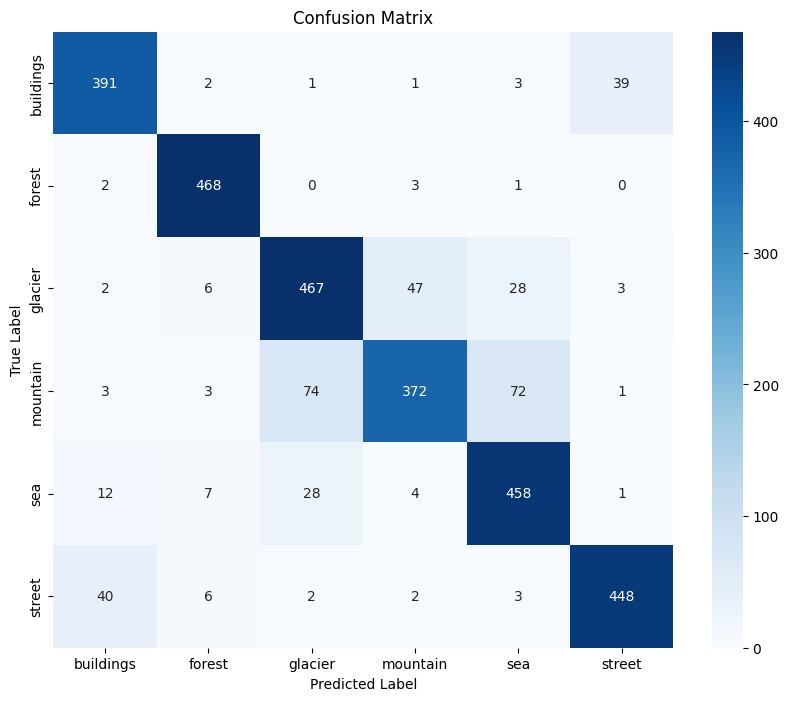

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


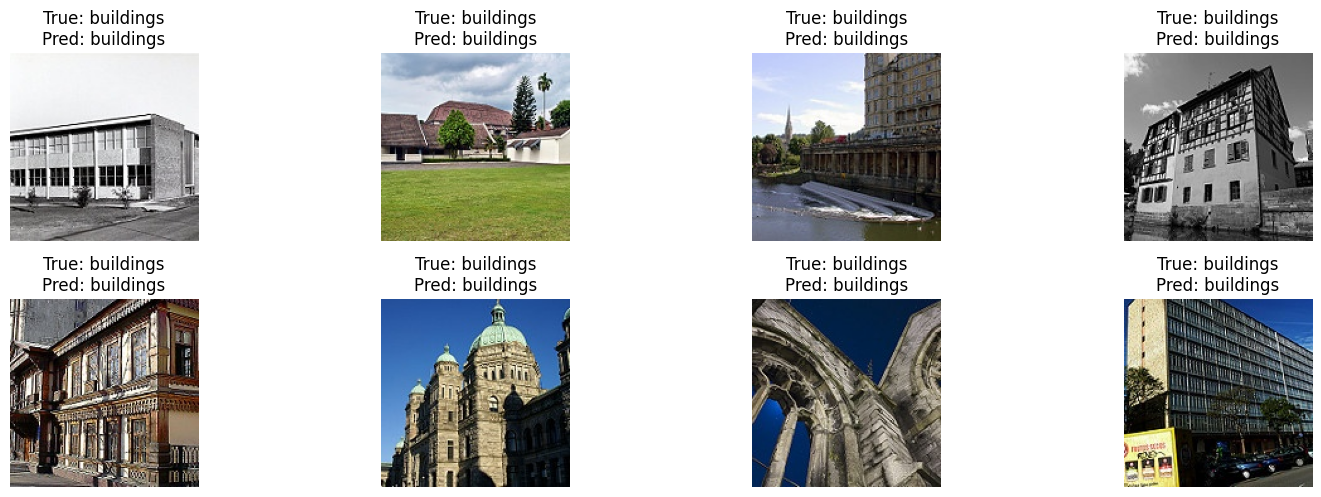

In [18]:
#  Model Evaluation

# Evaluate on test set
print("\nEvaluating deeper model on test set...")
deeper_test_loss, deeper_test_acc = deeper_model.evaluate(test_generator)
print(f"\nTest Accuracy: {deeper_test_acc:.4f} (Baseline: {test_acc:.4f})")
print(f"Test Loss: {deeper_test_loss:.4f} (Baseline: {test_loss:.4f})")

# Generate predictions
deeper_y_pred = deeper_model.predict(test_generator)
deeper_y_pred_classes = np.argmax(deeper_y_pred, axis=1)

# Classification report
print("\nClassification Report (Deeper Model):")
print(classification_report(y_true, deeper_y_pred_classes, target_names=class_names))

# Confusion matrix
plot_confusion_matrix(y_true, deeper_y_pred_classes, class_names)

# Sample predictions visualization
visualize_predictions(deeper_model, sample_generator)

**3.1.4 Experimentation and Comparative Analysis**

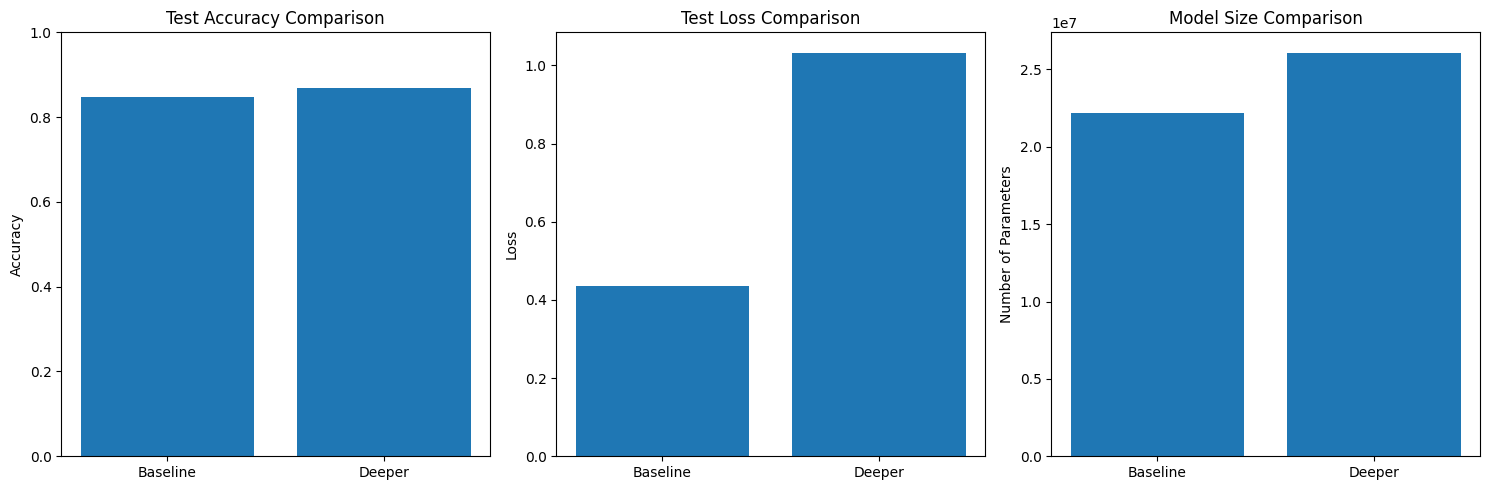


=== METRICS COMPARISON ===
Metric              Baseline       Deeper         Difference     
Accuracy            0.8480     0.8680     +0.0200
Loss                0.4348     1.0328     +0.5980
Parameters          22,181,126     26,095,302     +3,914,176

Class-wise F1-score Comparison:
Class          Baseline       Deeper         Improvement    
buildings      0.8165     0.8816     +0.0651
forest         0.9714     0.9689     -0.0025
glacier        0.7981     0.8302     +0.0322
mountain       0.8022     0.7799     -0.0224
sea            0.8480     0.8521     +0.0041
street         0.8569     0.9023     +0.0454


In [19]:
# Comparative metrics visualization
plt.figure(figsize=(15, 5))

# Accuracy comparison
plt.subplot(1, 3, 1)
plt.bar(['Baseline', 'Deeper'], [test_acc, deeper_test_acc])
plt.title('Test Accuracy Comparison')
plt.ylim(0, 1)
plt.ylabel('Accuracy')

# Loss comparison
plt.subplot(1, 3, 2)
plt.bar(['Baseline', 'Deeper'], [test_loss, deeper_test_loss])
plt.title('Test Loss Comparison')
plt.ylabel('Loss')

# Parameters comparison
plt.subplot(1, 3, 3)
plt.bar(['Baseline', 'Deeper'],
        [baseline_model.count_params(), deeper_model.count_params()])
plt.title('Model Size Comparison')
plt.ylabel('Number of Parameters')
plt.tight_layout()
plt.show()

# Detailed metrics comparison
print("\n=== METRICS COMPARISON ===")
print(f"{'Metric':<20}{'Baseline':<15}{'Deeper':<15}{'Difference':<15}")
print(f"{'Accuracy':<20}{test_acc:.4f}{'':<5}{deeper_test_acc:.4f}{'':<5}{deeper_test_acc-test_acc:+.4f}")
print(f"{'Loss':<20}{test_loss:.4f}{'':<5}{deeper_test_loss:.4f}{'':<5}{deeper_test_loss-test_loss:+.4f}")
print(f"{'Parameters':<20}{baseline_model.count_params():,}{'':<5}{deeper_model.count_params():,}{'':<5}"
      f"{deeper_model.count_params()-baseline_model.count_params():+,}")

# Class-wise comparison
def compare_class_metrics(y_true, pred1, pred2, class_names):
    report1 = classification_report(y_true, pred1, target_names=class_names, output_dict=True)
    report2 = classification_report(y_true, pred2, target_names=class_names, output_dict=True)

    print("\nClass-wise F1-score Comparison:")
    print(f"{'Class':<15}{'Baseline':<15}{'Deeper':<15}{'Improvement':<15}")
    for cls in class_names:
        f1_1 = report1[cls]['f1-score']
        f1_2 = report2[cls]['f1-score']
        print(f"{cls:<15}{f1_1:.4f}{'':<5}{f1_2:.4f}{'':<5}{f1_2-f1_1:+.4f}")

compare_class_metrics(y_true, y_pred_classes, deeper_y_pred_classes, class_names)

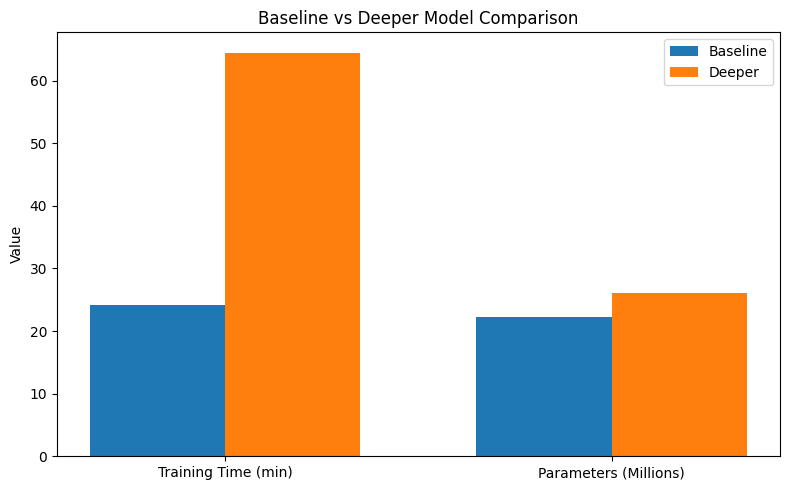


=== MODEL COMPARISON ===
Metric                    |   Baseline |     Deeper | Difference
-------------------------------------------------------
Training Time (min)       |      24.08 |      64.48 |      40.40
Parameters (Millions)     |      22.18 |      26.10 |       3.91


In [20]:
# === Use actual recorded training times ===
baseline_training_minutes = baseline_training_time / 60
deeper_training_minutes = deeper_training_time / 60

# === Count parameters in millions ===
baseline_params = baseline_model.count_params() / 1e6
deeper_params = deeper_model.count_params() / 1e6

# === Define metrics and values ===
metrics = ['Training Time (min)', 'Parameters (Millions)']
baseline_vals = [baseline_training_minutes, baseline_params]
deeper_vals = [deeper_training_minutes, deeper_params]

# === Plot bar chart for comparison ===
x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width / 2, baseline_vals, width, label='Baseline')
plt.bar(x + width / 2, deeper_vals, width, label='Deeper')

plt.ylabel('Value')
plt.title('Baseline vs Deeper Model Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.tight_layout()
plt.show()

# === Print comparison table ===
print("\n=== MODEL COMPARISON ===")
print(f"{'Metric':<25} | {'Baseline':>10} | {'Deeper':>10} | {'Difference':>10}")
print("-" * 55)
print(f"{'Training Time (min)':<25} | {baseline_vals[0]:>10.2f} | {deeper_vals[0]:>10.2f} | {deeper_vals[0] - baseline_vals[0]:>10.2f}")
print(f"{'Parameters (Millions)':<25} | {baseline_vals[1]:>10.2f} | {deeper_vals[1]:>10.2f} | {deeper_vals[1] - baseline_vals[1]:>10.2f}")


Training with SGD optimizer...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 79s 213ms/step - accuracy: 0.4164 - loss: 1.4130 - val_accuracy: 0.5790 - val_loss: 1.0669
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 72s 201ms/step - accuracy: 0.5620 - loss: 1.0923 - val_accuracy: 0.5737 - val_loss: 1.0396
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 72s 204ms/step - accuracy: 0.6115 - loss: 0.9808 - val_accuracy: 0.5776 - val_loss: 1.0321
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 73s 204ms/step - accuracy: 0.6198 - loss: 0.9620 - val_accuracy: 0.6606 - val_loss: 0.8922
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 73s 204ms/step - accuracy: 0.6544 - loss: 0.9067 - val_accuracy: 0.6577 - val_loss: 0.8945
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 72s 203ms/step - accuracy: 0.6719 - loss: 0.8643 - val_accuracy: 0.6828 - val_loss: 0.8485
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 73s 204ms/step - accuracy: 0.6876 - loss: 0.8405 - val_accuracy: 0.6938 - val_loss: 0.8093
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 72s 203ms/step - accuracy: 0.7010 - loss: 0

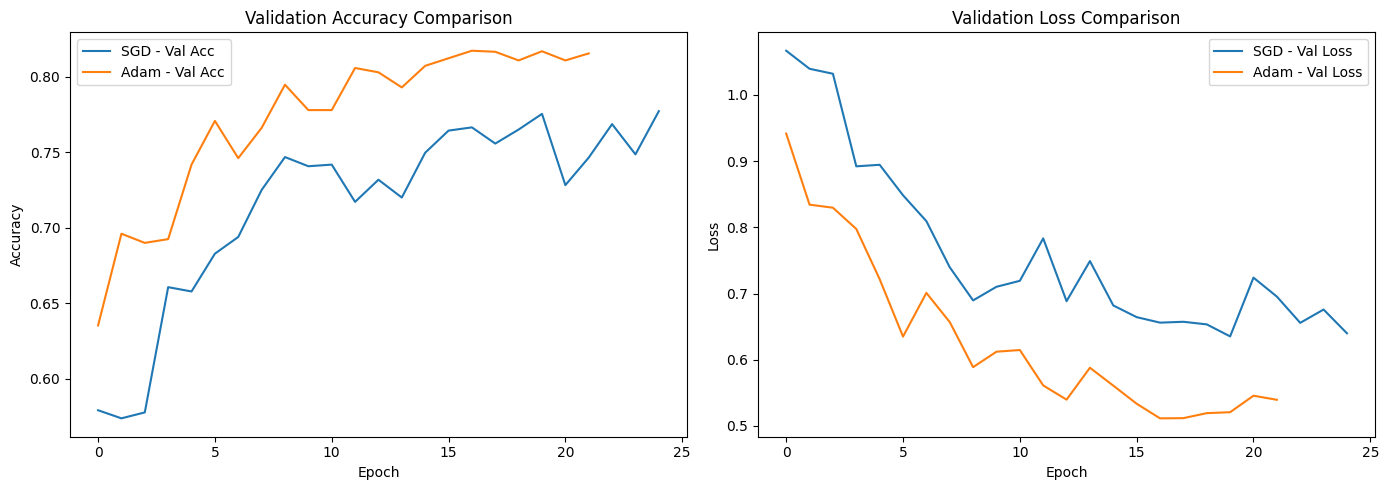

In [21]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt


# Create a simple CNN model
def create_simple_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')  # assuming 6 classes
    ])
    return model

# Callbacks
def get_callbacks(name):
    return [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(f'best_model_{name}.keras', monitor='val_accuracy', save_best_only=True)
    ]

# Function to compile, train, and evaluate a model
def train_and_evaluate(optimizer_name, optimizer_instance):
    print(f"\nTraining with {optimizer_name} optimizer...")
    model = create_simple_model()
    model.compile(optimizer=optimizer_instance,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=get_callbacks(optimizer_name.lower()),
        verbose=1
    )

    test_loss, test_acc = model.evaluate(test_generator)
    print(f"\n{optimizer_name} - Test Accuracy: {test_acc:.4f}")
    print(f"{optimizer_name} - Test Loss: {test_loss:.4f}")

    return history, test_acc, test_loss

# Train with SGD
history_sgd, acc_sgd, loss_sgd = train_and_evaluate("SGD", tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9))

# Train with Adam
history_adam, acc_adam, loss_adam = train_and_evaluate("Adam", tf.keras.optimizers.Adam())

# Plot comparison
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_sgd.history['val_accuracy'], label='SGD - Val Acc')
plt.plot(history_adam.history['val_accuracy'], label='Adam - Val Acc')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_sgd.history['val_loss'], label='SGD - Val Loss')
plt.plot(history_adam.history['val_loss'], label='Adam - Val Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Print comprehensive results
print("\n=== FINAL COMPARISON ===")
print(f"{'Metric':<15}{'Adam':<15}{'SGD':<15}{'Difference':<15}")
print(f"{'Test Accuracy':<15}{acc_adam:.4f}{'':<5}{acc_sgd:.4f}{'':<5}{acc_adam - acc_sgd:+.4f}")
print(f"{'Test Loss':<15}{loss_adam:.4f}{'':<5}{loss_sgd:.4f}{'':<5}{loss_adam - loss_sgd:+.4f}")
print(f"{'Epochs Trained':<15}{len(history_adam.epoch)}{'':<5}{len(history_sgd.epoch)}{'':<5}"
      f"{len(history_adam.epoch) - len(history_sgd.epoch):+d}")


print("\n=== TRAINING DIAGNOSTICS ===")
print(f"Final Training Accuracy (Adam): {history_adam.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy (Adam): {history_adam.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss (Adam): {history_adam.history['loss'][-1]:.4f}")
print(f"Final Validation Loss (Adam): {history_adam.history['val_loss'][-1]:.4f}")


=== FINAL COMPARISON ===
Metric         Adam           SGD            Difference     
Test Accuracy  0.8463     0.8297     +0.0167
Test Loss      0.4596     0.4994     -0.0399
Epochs Trained 22     25     -3

=== TRAINING DIAGNOSTICS ===
Final Training Accuracy (Adam): 0.8277
Final Validation Accuracy (Adam): 0.8155
Final Training Loss (Adam): 0.4722
Final Validation Loss (Adam): 0.5394


In [23]:
# Challenges and Observations

# Hardware information
try:
    from tensorflow.python.client import device_lib
    devices = device_lib.list_local_devices()
    gpu_devices = [d for d in devices if d.device_type == 'GPU']
    tpu_devices = [d for d in devices if d.device_type == 'TPU']

    print("\n=== HARDWARE ACCELERATION ===")
    if gpu_devices:
        print(f"GPU Detected: {gpu_devices[0].physical_device_desc}")
    elif tpu_devices:
        print(f"TPU Detected: {tpu_devices[0].physical_device_desc}")
    else:
        print("No GPU/TPU detected - using CPU")
except:
    print("\nCould not detect hardware information")


=== HARDWARE ACCELERATION ===
GPU Detected: device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


I0000 00:00:1747160251.593280      31 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747160251.593533      31 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# **3.2 Part B: Fine-Tuning a Pre-Trained Model (Transfer Learning).**

**3.2.1 Loading and Adapting a Pre-Trained Model**

In [24]:
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam


class_names = ['class0', 'class1', 'class2', 'class3', 'class4', 'class5']

# Select and load pre-trained model (VGG16 in this case)
def load_pretrained_model(model_name='VGG16'):
    input_shape = (150, 150, 3)
    num_classes = len(class_names)

    if model_name == 'VGG16':
        base_model = VGG16(weights='imagenet',
                           include_top=False,
                           input_shape=input_shape)
    elif model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet',
                              include_top=False,
                              input_shape=input_shape)
    elif model_name == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet',
                                 include_top=False,
                                 input_shape=input_shape)
    else:
        raise ValueError("Model not supported. Choose from: VGG16, ResNet50, InceptionV3")

    # Freeze convolutional layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add new classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model, base_model

# Let's use VGG16 as our base model
transfer_model, base_model = load_pretrained_model('VGG16')

# Compile the model
transfer_model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Print model summary
print("Modified Transfer Learning Model Architecture:")
transfer_model.summary()

# Visualize base model layers (with safe handling for missing output_shape)
print("\nOriginal Base Model Layers:")
for i, layer in enumerate(base_model.layers):
    output_shape = getattr(layer, 'output_shape', 'N/A')
    print(f"{i:3d} {layer.name:20s} {output_shape} {'trainable' if layer.trainable else 'frozen'}")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Modified Transfer Learning Model Architecture:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         131,3

 Total params: 14,847,558 (56.64 MB)

 Trainable params: 132,870 (519.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)


Original Base Model Layers:
  0 input_layer_4        N/A frozen
  1 block1_conv1         N/A frozen
  2 block1_conv2         N/A frozen
  3 block1_pool          N/A frozen
  4 block2_conv1         N/A frozen
  5 block2_conv2         N/A frozen
  6 block2_pool          N/A frozen
  7 block3_conv1         N/A frozen
  8 block3_conv2         N/A frozen
  9 block3_conv3         N/A frozen
 10 block3_pool          N/A frozen
 11 block4_conv1         N/A frozen
 12 block4_conv2         N/A frozen
 13 block4_conv3         N/A frozen
 14 block4_pool          N/A frozen
 15 block5_conv1         N/A frozen
 16 block5_conv2         N/A frozen
 17 block5_conv3         N/A frozen
 18 block5_pool          N/A frozen


**3.2.2 Model Training and Fine - Tuning :**

Found 11196 images belonging to 6 classes.
Found 2796 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.

=== FEATURE EXTRACTION PHASE ===
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


350/350 ━━━━━━━━━━━━━━━━━━━━ 87s 236ms/step - accuracy: 0.5749 - loss: 1.0533 - val_accuracy: 0.7386 - val_loss: 0.6453
Epoch 2/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 74s 207ms/step - accuracy: 0.7485 - loss: 0.6544 - val_accuracy: 0.7815 - val_loss: 0.5750
Epoch 3/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 74s 207ms/step - accuracy: 0.7844 - loss: 0.5744 - val_accuracy: 0.7747 - val_loss: 0.5800
Epoch 4/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 74s 207ms/step - accuracy: 0.7834 - loss: 0.5766 - val_accuracy: 0.7911 - val_loss: 0.5574
Epoch 5/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 75s 210ms/step - accuracy: 0.7877 - loss: 0.5478 - val_accuracy: 0.8104 - val_loss: 0.5220
Epoch 6/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 74s 209ms/step - accuracy: 0.8072 - loss: 0.5133 - val_accuracy: 0.7865 - val_loss: 0.5522
Epoch 7/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 75s 209ms/step - accuracy: 0.8051 - loss: 0.5218 - val_accuracy: 0.7954 - val_loss: 0.5405
Epoch 8/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 74s 209ms/step - accuracy: 0.7945 - loss: 0.5362 - val

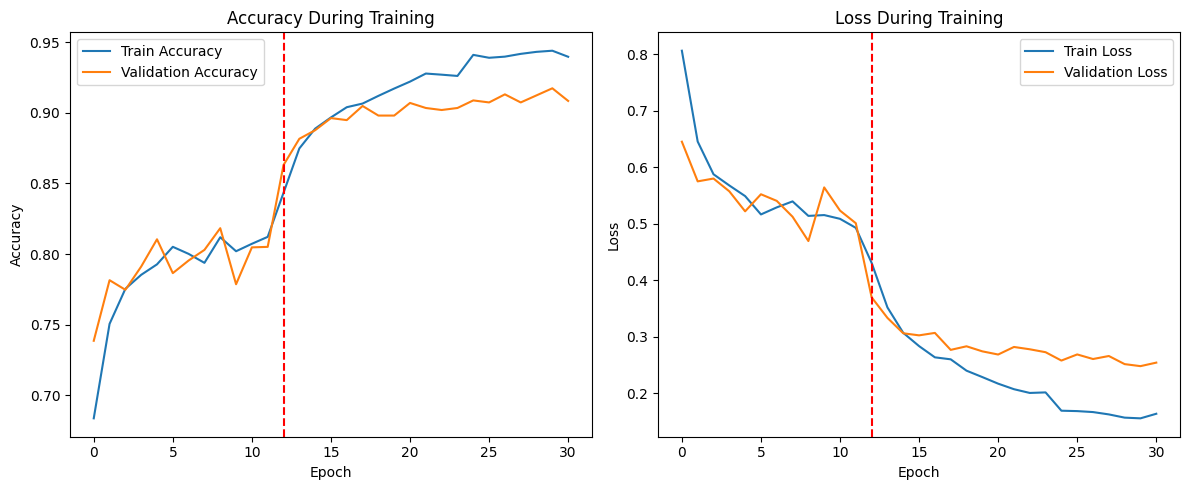

In [25]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Define paths and parameters
train_clean_path = '/kaggle/working/train_clean'  # Replace with actual path to training data
test_clean_path = '/kaggle/working/test_clean'    # Replace with actual path to test data
IMG_SIZE = (150, 150)  # Standard size for all images
BATCH_SIZE = 32

num_classes = 6  # Matches the 6 classes found in your output

# Create data generators with proper image size
def create_generators():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_clean_path,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        train_clean_path,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    test_generator = test_datagen.flow_from_directory(
        test_clean_path,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

# Initialize pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

base_model.trainable = False  # Freeze base model for feature extraction

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
frozen_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
frozen_model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Create new generators with proper size
train_gen, val_gen, test_gen = create_generators()

# Feature Extraction Phase (Frozen Base)
print("\n=== FEATURE EXTRACTION PHASE ===")
feature_extraction_history = frozen_model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)

# Fine-Tuning Phase (Unfreeze some layers)
def fine_tune_model(model, base_model):
    # Unfreeze top layers of base model
    for layer in base_model.layers[-10:]:
        layer.trainable = True

    # Recompile with lower learning rate
    model.compile(
        optimizer=SGD(learning_rate=0.0001, momentum=0.9),  # Lower LR for fine-tuning
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

print("\n=== FINE-TUNING PHASE ===")
tunable_model = fine_tune_model(frozen_model, base_model)
fine_tune_history = tunable_model.fit(
    train_gen,
    epochs=30,
    initial_epoch=feature_extraction_history.epoch[-1],
    validation_data=val_gen,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
    ],
    verbose=1
)

# Combine histories for plotting
def combine_histories(hist1, hist2):
    combined = {}
    for key in hist1.history.keys():
        combined[key] = hist1.history[key] + hist2.history[key]
    return combined

full_history = combine_histories(feature_extraction_history, fine_tune_history)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(full_history['accuracy'], label='Train Accuracy')
plt.plot(full_history['val_accuracy'], label='Validation Accuracy')
plt.axvline(len(feature_extraction_history.epoch), color='r', linestyle='--')
plt.title('Accuracy During Training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(full_history['loss'], label='Train Loss')
plt.plot(full_history['val_loss'], label='Validation Loss')
plt.axvline(len(feature_extraction_history.epoch), color='r', linestyle='--')
plt.title('Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
# Verify input shape
print("\nModel Input Shape:", frozen_model.input_shape)
print("Generator Output Shape:", next(train_gen)[0].shape[1:])


Model Input Shape: (None, 150, 150, 3)
Generator Output Shape: (150, 150, 3)


In [27]:
# Verify output layer configuration
print("\nModel Output Configuration:")
print("Number of classes:", frozen_model.output_shape[1])
print("Class indices:", train_gen.class_indices)

# Sample prediction test
sample_batch = next(train_gen)
predictions = frozen_model.predict(sample_batch[0])
print("\nSample predictions shape:", predictions.shape)
print("Predicted class for first sample:", np.argmax(predictions[0]))
print("Actual class:", np.argmax(sample_batch[1][0]))


Model Output Configuration:
Number of classes: 6
Class indices: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step

Sample predictions shape: (32, 6)
Predicted class for first sample: 0
Actual class: 0


**3.2.3 Model Evaluation and Prediction**

In [28]:
# Evaluate all models consistently
def comprehensive_evaluation(model, model_name, test_generator):
    # Evaluate metrics
    test_loss, test_acc = model.evaluate(test_generator)
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    # Classification report
    report = classification_report(y_true, y_pred_classes,
                                 target_names=class_names, output_dict=True)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    return {
        'model': model_name,
        'accuracy': test_acc,
        'loss': test_loss,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1': report['weighted avg']['f1-score'],
        'confusion_matrix': cm
    }

# Evaluate all models
print("\n=== COMPREHENSIVE EVALUATION ===")
results = {
    'baseline': comprehensive_evaluation(baseline_model, "Baseline", test_gen),
    'deeper': comprehensive_evaluation(deeper_model, "Deeper", test_gen),
    'transfer': comprehensive_evaluation(tunable_model, "Transfer", test_gen)
}

# Create comparison dataframe
results_df = pd.DataFrame.from_dict(results, orient='index')
print("\nModel Comparison:")
display(results_df[['accuracy', 'loss', 'precision', 'recall', 'f1']].style
       .background_gradient(cmap='Blues', subset=['accuracy', 'f1'])
       .background_gradient(cmap='Reds_r', subset=['loss']))


=== COMPREHENSIVE EVALUATION ===
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8225 - loss: 0.4347
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.8893 - loss: 0.9720
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.9282 - loss: 0.2119
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step

Model Comparison:


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


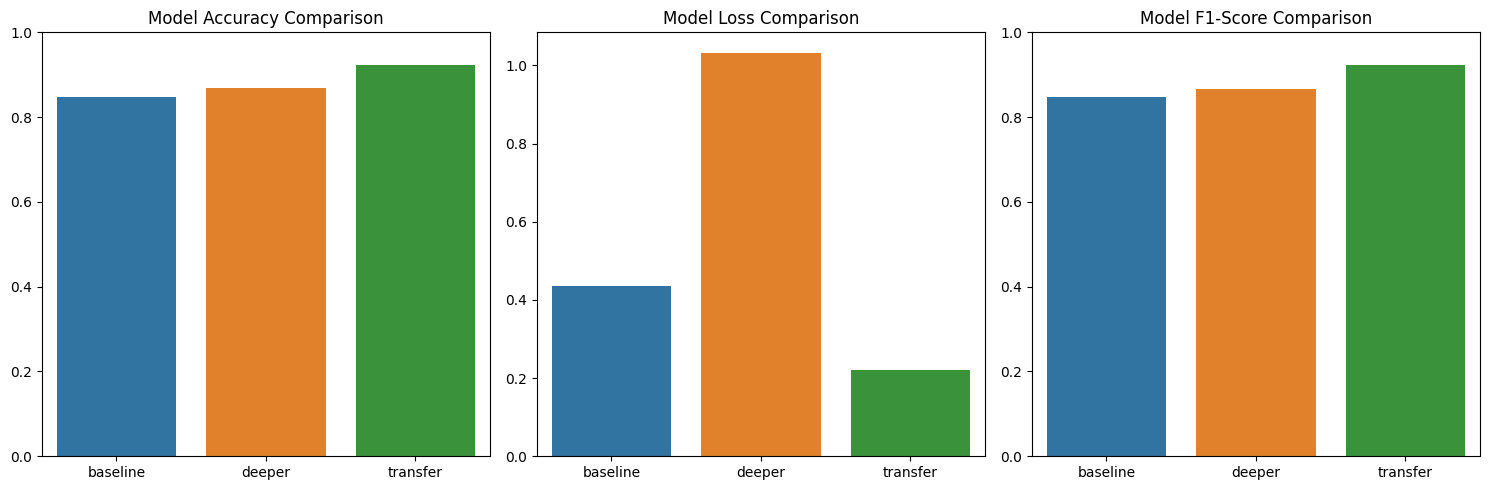

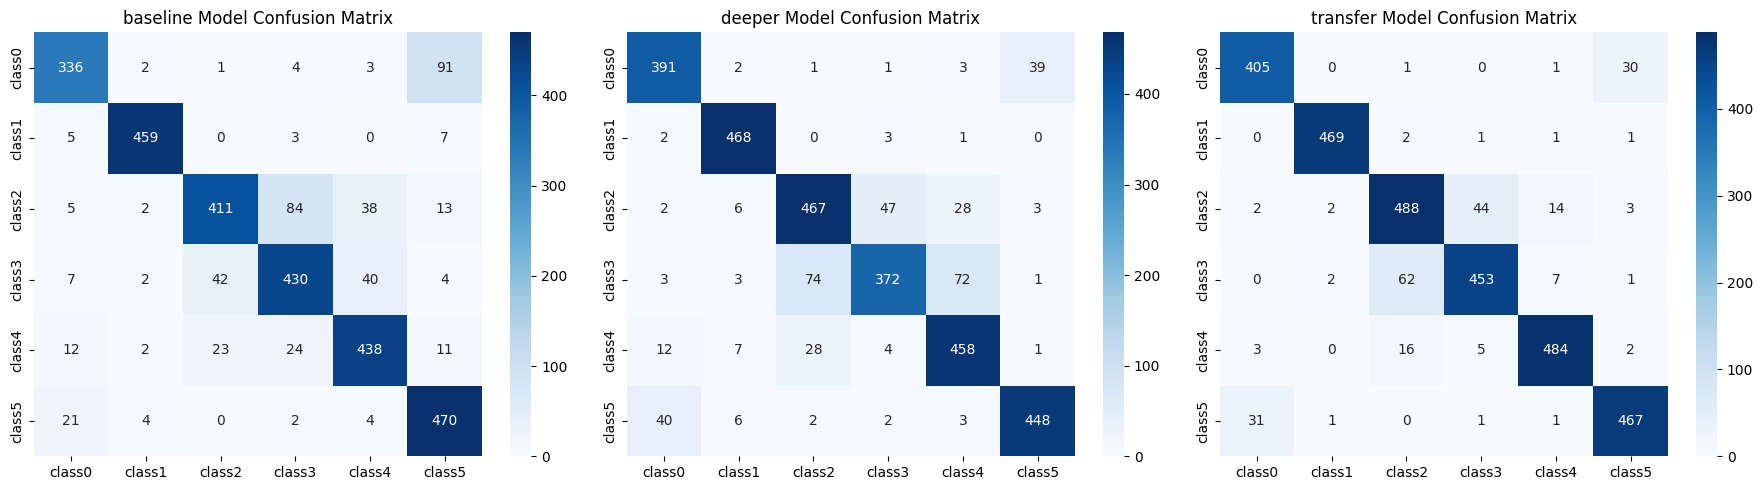

In [29]:
# Plot model comparison
plt.figure(figsize=(15, 5))

# Accuracy comparison
plt.subplot(1, 3, 1)
sns.barplot(x=list(results.keys()), y=[r['accuracy'] for r in results.values()])
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)

# Loss comparison
plt.subplot(1, 3, 2)
sns.barplot(x=list(results.keys()), y=[r['loss'] for r in results.values()])
plt.title('Model Loss Comparison')

# F1-score comparison
plt.subplot(1, 3, 3)
sns.barplot(x=list(results.keys()), y=[r['f1'] for r in results.values()])
plt.title('Model F1-Score Comparison')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Confusion matrix comparison
plt.figure(figsize=(18, 5))
for i, (name, res) in enumerate(results.items()):
    plt.subplot(1, 3, i+1)
    sns.heatmap(res['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{name} Model Confusion Matrix')
plt.tight_layout()
plt.show()

In [30]:
# Class-wise performance comparison
class_results = {}
for cls in class_names:
    class_results[cls] = {
        'baseline': results['baseline']['precision'],
        'deeper': results['deeper']['precision'],
        'transfer': results['transfer']['precision']}

class_df = pd.DataFrame(class_results)
print("\nClass-wise Precision Comparison:")
display(class_df.style.background_gradient(cmap='Blues'))


Class-wise Precision Comparison:


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


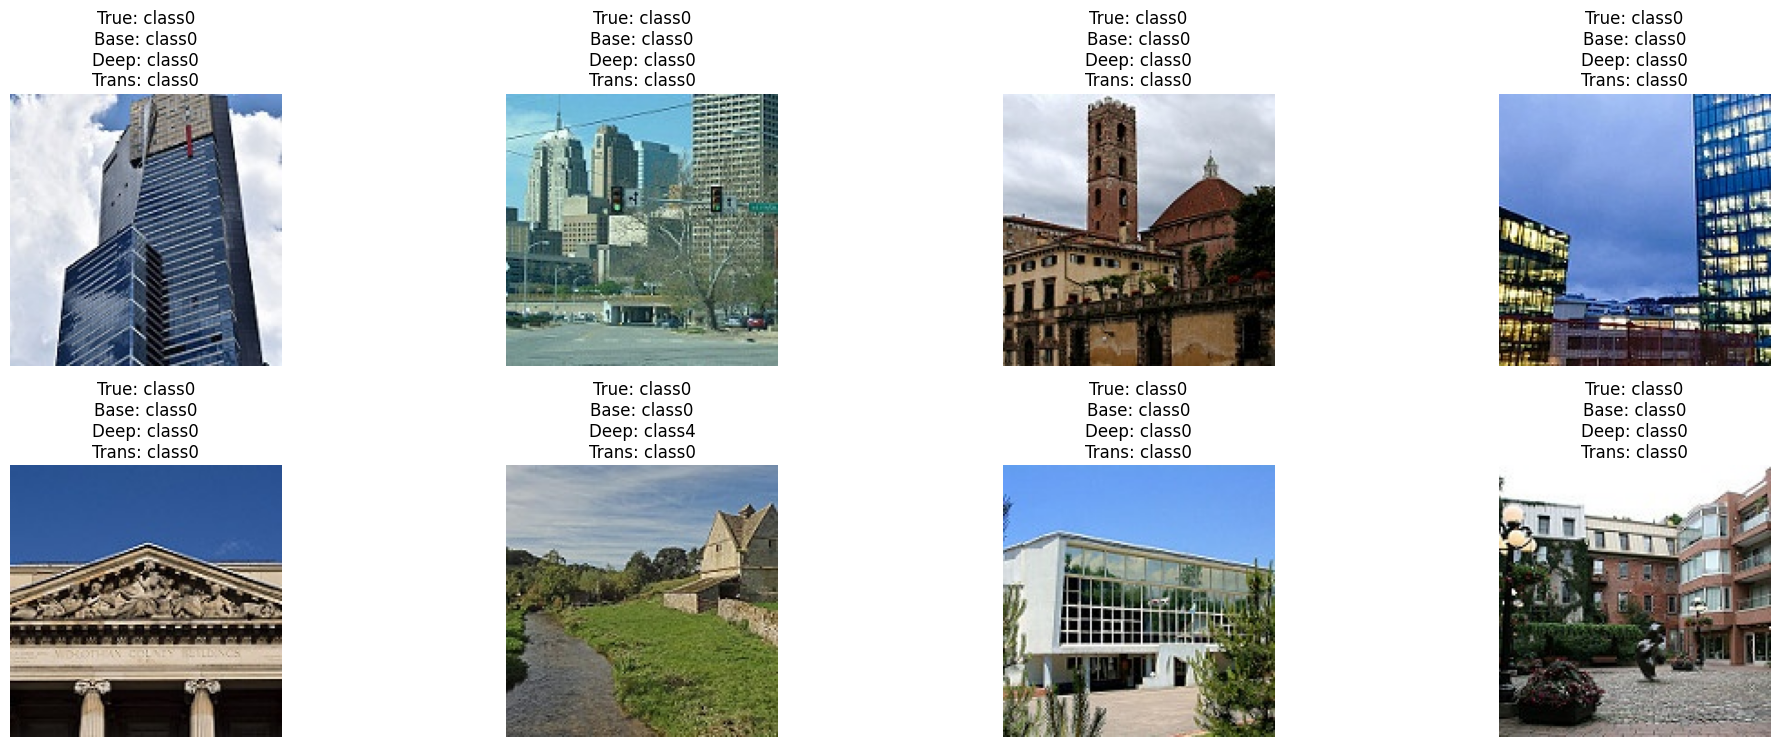

In [31]:
# Get consistent test samples
x_samples, y_samples = next(test_gen)
y_true_samples = np.argmax(y_samples, axis=1)

# Get predictions from all models
baseline_pred = baseline_model.predict(x_samples)
deeper_pred = deeper_model.predict(x_samples)
transfer_pred = tunable_model.predict(x_samples)

# Visualize comparison
plt.figure(figsize=(20, 15))
for i in range(8):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_samples[i])
    true_class = class_names[y_true_samples[i]]

    # Get predicted classes
    b_pred = class_names[np.argmax(baseline_pred[i])]
    d_pred = class_names[np.argmax(deeper_pred[i])]
    t_pred = class_names[np.argmax(transfer_pred[i])]

    plt.title(f"True: {true_class}\n"
              f"Base: {b_pred}\n"
              f"Deep: {d_pred}\n"
              f"Trans: {t_pred}")
    plt.axis('off')
plt.tight_layout()
plt.show()